# 1. Import Library

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

# 2. Load Dataset

In [4]:
sdir=r'/content/drive/MyDrive/Prediksi Penyakit Tanaman Padi/Dataset_padi'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths                 labels
0  /content/drive/MyDrive/Prediksi Penyakit Tanam...  Bacterial leaf blight
1  /content/drive/MyDrive/Prediksi Penyakit Tanam...  Bacterial leaf blight
2  /content/drive/MyDrive/Prediksi Penyakit Tanam...  Bacterial leaf blight
3  /content/drive/MyDrive/Prediksi Penyakit Tanam...  Bacterial leaf blight
4  /content/drive/MyDrive/Prediksi Penyakit Tanam...  Bacterial leaf blight
labels
Bacterial leaf blight    40
Leaf smut                40
Brown spot               40
Name: count, dtype: int64


# 3. Split Data

In [5]:
train_split = 0.8
test_split = 0.1
valid_split = 0.1

train_df, temp_df = train_test_split(
    df,
    train_size=train_split,
    stratify=df['labels'],
    shuffle=True,
    random_state=123
)

test_ratio = test_split / (test_split + valid_split)

test_df, valid_df = train_test_split(
    temp_df,
    train_size=test_ratio,
    stratify=temp_df['labels'],
    shuffle=True,
    random_state=123
)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  96   test_df length:  12   valid_df length:  12


# 4. Train & Test Data

In [6]:
height = 128
width = 128
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)
test_batch_size = sorted(
    [int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

print('test batch size: ', test_batch_size, '  test steps: ', test_steps)

gen = ImageDataGenerator(rescale=1. / 255,)

train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                    class_mode='categorical', color_mode='rgb',shuffle=True, batch_size=batch_size)

validgen = ImageDataGenerator(rescale=1. / 255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                         class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen = ImageDataGenerator(rescale=1. / 255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes = list(train_gen.class_indices.keys())
print("Classes: ", classes)

class_count = len(classes)
print("Number of classes: ", class_count)


test batch size:  12   test steps:  1
Found 96 validated image filenames belonging to 3 classes.
Found 12 validated image filenames belonging to 3 classes.
Found 12 validated image filenames belonging to 3 classes.
Classes:  ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Number of classes:  3


# 5. Show Image Examples

In [12]:
def show_image_samples(gen, class_indices):
    classes = list(class_indices.keys())
    images, labels = next(gen)
    num_images = min(len(labels), 25)

    fig = plt.figure(figsize=(15, 15))
    gs = GridSpec(5, 5, figure=fig)

    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)

        index = np.argmax(labels[i])
        class_name = classes[index]

        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')

    plt.show()

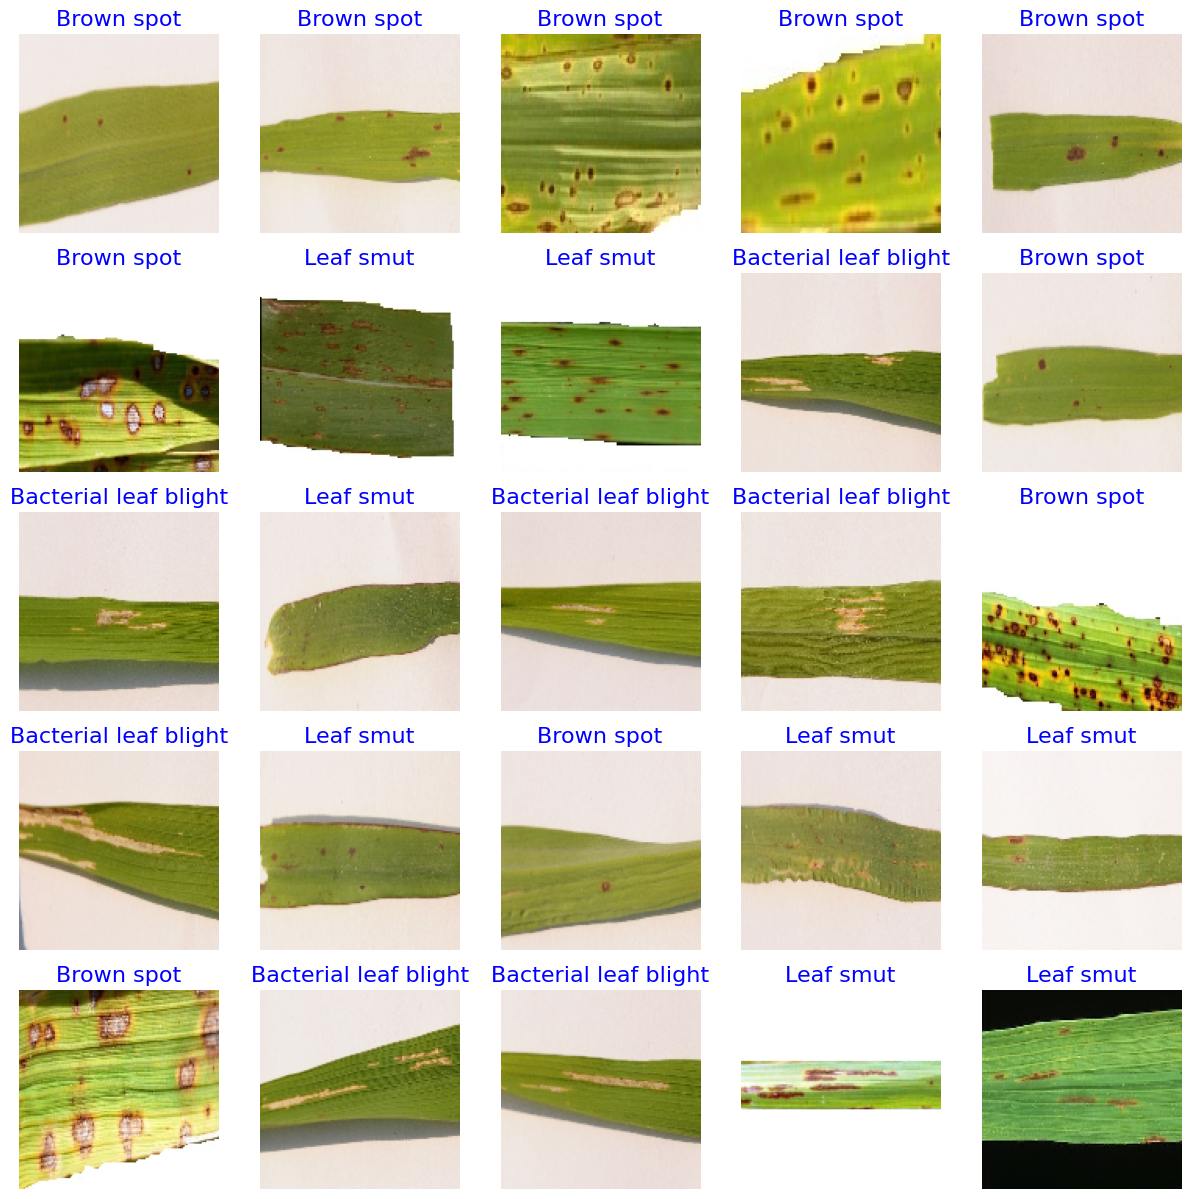

In [13]:
show_image_samples(train_gen, train_gen.class_indices)

# 6. Create Model

In [14]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(128,128,3)))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [16]:
base_model.trainable = False

In [20]:
model_name='Xception'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

Building model with <Functional name=xception, built=True>


In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 4, 4, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 32)            │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,451,723 (81.83 MB)

 Trainable params: 590,243 (2.25 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [22]:
epochs =10

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 9s/step - accuracy: 0.3125 - loss: 1.8619 - val_accuracy: 0.6667 - val_loss: 0.6486
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7448 - loss: 0.7166 - val_accuracy: 0.8333 - val_loss: 0.8518
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7049 - loss: 0.6948 - val_accuracy: 0.8333 - val_loss: 0.5625
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.9132 - loss: 0.3245 - val_accuracy: 0.8333 - val_loss: 0.5824
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.9340 - loss: 0.2346 - val_accuracy: 0.8333 - val_loss: 0.6141
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8872 - loss: 0.3223 - val_accuracy: 0.8333 - val_loss: 0.7184
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9253 - loss: 0.2305 - val_accuracy: 0.8333 - val_loss: 0.8309
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 8s/step - accuracy: 0.9028 - loss: 0.1903 - val_accuracy: 0.9167 - val_loss: 0.9143
Epoch 9/10
2/2 ━━━━━

#7. Define function

In [23]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [24]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [32]:
def print_info(test_gen, preds, print_code, save_dir, subject):
    class_dict = test_gen.class_indices
    labels = np.array(test_gen.labels)
    file_names = test_gen.filenames
    new_dict = {v: k for k, v in class_dict.items()}
    classes = list(new_dict.values())

    # Simpan dictionary ke file
    dict_path = os.path.join(save_dir, f"{subject}-{len(classes)}.txt")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with open(dict_path, 'w') as x_file:
        x_file.write(str(new_dict))

    # Error detection
    errors, error_list, true_class, pred_class, prob_list = 0, [], [], [], []
    y_pred = []
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        y_pred.append(pred_index)
        if pred_index != true_index:
            errors += 1
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])

    # Error printing
    if print_code != 0 and errors > 0:
        r = min(print_code, errors)
        for i in range(r):
            fname = os.path.split(error_list[i])[1]
            msg = f"{fname:^28s} {pred_class[i]:^28s} {true_class[i]:^28s} {prob_list[i]:.4f}"
            print_in_color(msg, (255, 255, 255), (55, 65, 60))
    elif errors == 0:
        print_in_color("No errors detected!", (0, 255, 0), (55, 65, 80))

    # Confusion matrix
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=list(new_dict.values()), yticklabels=list(new_dict.values()))
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Classification report
    clr = classification_report(y_true, y_pred, target_names=classes)
    print(f"Classification Report:\n{clr}")


# 8. Evaluate

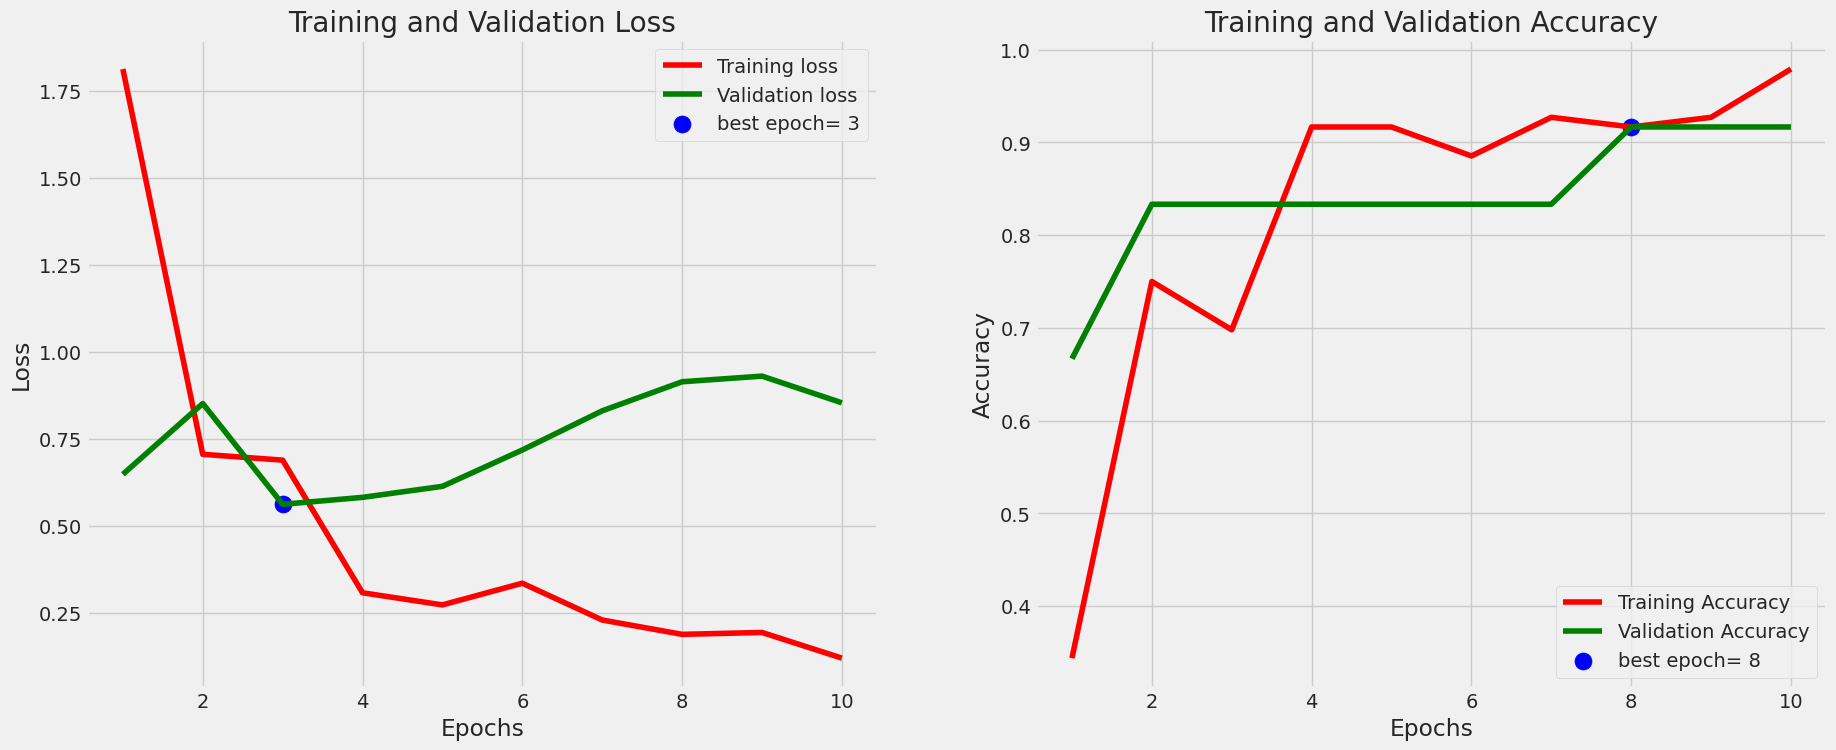

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8333 - loss: 0.6269   
accuracy on the test set is 83.33 %



In [33]:
tr_plot(history, 0)
save_dir = r'/content/drive/MyDrive/Prediksi Penyakit Tanaman Padi/Dataset_padi'
subject = 'padi'

acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

save_id = "Xception.h5"
save_loc = os.path.join(save_dir, save_id)

model.save(save_loc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


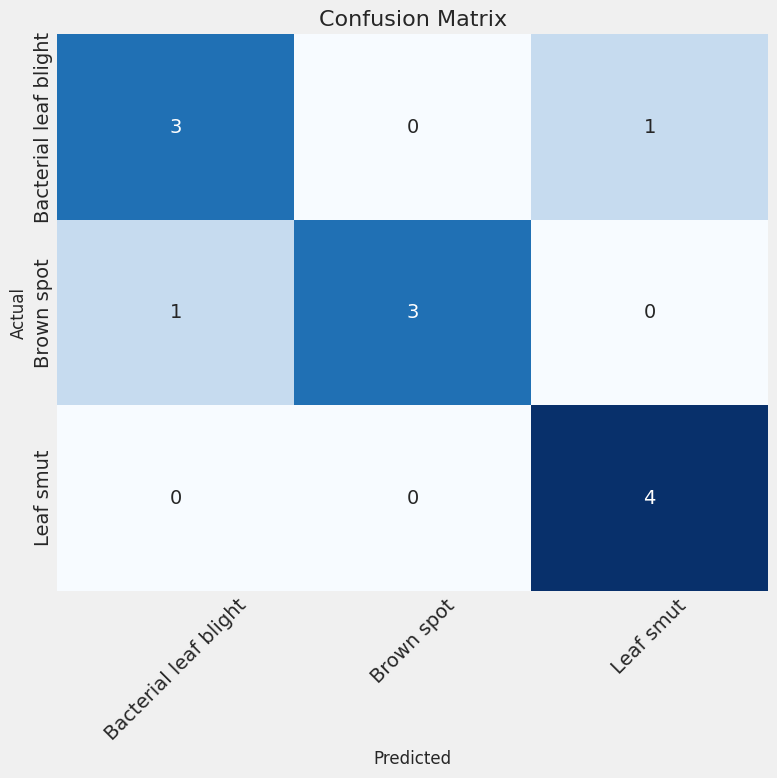

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.75      0.75      0.75         4
           Brown spot       1.00      0.75      0.86         4
            Leaf smut       0.80      1.00      0.89         4

             accuracy                           0.83        12
            macro avg       0.85      0.83      0.83        12
         weighted avg       0.85      0.83      0.83        12



In [34]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )